In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import re
import io
import time
import zipfile

# Подготовка
## Скачать датасет
Исходный датасет скачаем по [ссылке](http://www.manythings.org/anki/). Нам нужен **rus-eng.zip**. Разархивируем его в рабочую директорию. Это можно сделать как в ручную, так и с использованием python.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
WORK_PATH = r'/content/drive/My Drive/Colab Notebooks/seq2seq'
PATH_TO_ZIP = os.path.join(WORK_PATH, 'rus-eng.zip')
PATH_TO_FILE = os.path.join(WORK_PATH, 'rus.txt')

with zipfile.ZipFile(PATH_TO_ZIP, 'r') as zip_ref:
    zip_ref.extractall(WORK_PATH)

In [4]:
with open(PATH_TO_FILE, 'r') as f:
  num_of_pairs = len(f.read().split('\n')) - 1

## Обработка датасета
Необходимо преобразовать RAW текстовые данные в пайплайн для использования с tensorflow.

In [5]:
def preprocess_sentence(w):
    w = w.lower()
    # поставить пробел между знаками
    w = re.sub(r"([?.!,])", r" \1 ", w)
    # убрать лишние пробелы
    w = re.sub(r'[" "]+', " ", w)
    # убрать лишние знаки
    w = re.sub(r"[^a-zа-яё?.!,']+", " ", w)
    # разделить слова
    w = w.strip()
    # добавить токены начала и конца строки
    w = '<start> ' + w + ' <end>'
    return w

In [6]:
preprocess_sentence('Здравствуйте! Меня зовут Владислав.')

'<start> здравствуйте ! меня зовут владислав . <end>'

* **create_dataset** - разделяет строку в файле по табуляции возвращает пару предложений на русском и английском языке, обработанную функцией preprocess_sentence
* **tokenize** - Используя Tokenizer присваивает каждому слову номер и преобразует предложение в последовательность токенов (номеров). Так-как предложения разной длины, а для обучения необходима единая длина предложений, нужно заполнить короткие предложения pad токенами (обычно это нули). Функция также возвращает объект токенайзера, необходимого для последующей работы.
* **load_dataset** - объединяет предыдущие функции и выводит результат


In [7]:
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8-sig').read().strip().split('\n')
  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:2]]  for l in lines[:num_examples]]
  return zip(*word_pairs)
  
def tokenize(lang):
    lang_tokenizer = keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    return tensor, lang_tokenizer

def load_dataset(path, num_examples=None):
    # creating cleaned input, output pairs
    targ_lang, inp_lang = create_dataset(path, num_examples)
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

Код ниже создает объект tf.data.Dataset

In [8]:
# Можно поэкспериментировать с размером датасета. Чем меньше, тем быстрее обучение, но хуже модель. Используем 70%
num_examples = int(num_of_pairs*0.7)
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(PATH_TO_FILE, num_examples)
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)
# Посчитать максимальную длину тензоров
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

# Структура модели Transformer
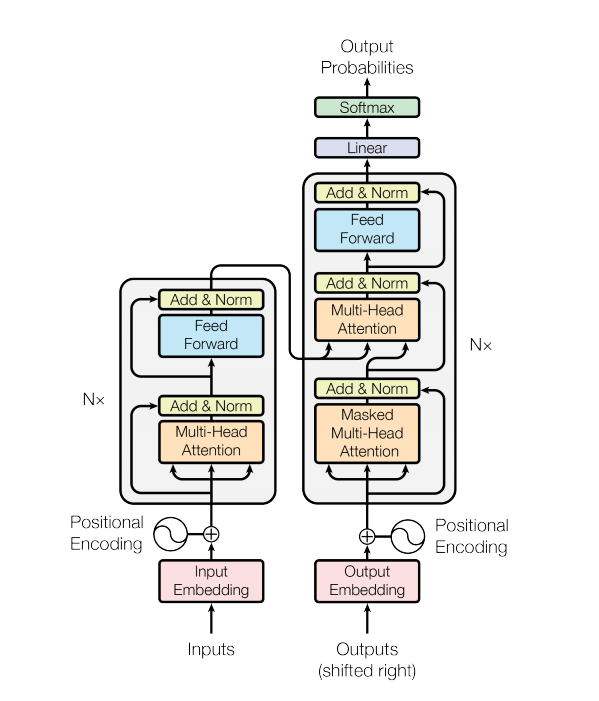

Левая часть - энкодер. Он принимает в качестве входных данных набор предложений
представленных как последовательности идентификаторов слов (предобрабодка была представлена выше). Входная форма - [размер пакета, макс. длина входного предложения]), и он кодирует каждое слово в m-мерное представление (таким образом, форма вывода энекодера будет [размер пакета, максимальная длина входного предложения, m-мерное представление]). Верхняя часть энкодера сложена N раз.

Правая часть - декодер. Во время обучения он принимает на вход целевое предложение (также представленное как последовательность идентификаторов слов), сдвинутое на один временной шаг вправо (маркер начала последовательности вставляется в начало). Он также принимает выходные данные энкодера (то есть стрелки, идущие с левой стороны). Верхняя часть декодера также складывается N раз, и конечные выходные данные стека кодировщика подаются в декодер на каждом из этих N уровней. Как и раньше, декодер выводит вероятность для каждого возможного следующего слова на каждом временном шаге (его форма вывода - [размер пакета, максимальная длина выходного предложения, длина словаря]). 

Во время предсказания декодер не может получать информацию о целях, поэтому мы подаем ему ранее выведенные слова (начиная с токена начала последовательности \<start>). Таким образом, модель необходимо вызывать неоднократно, предсказывая еще одно слово на каждом этапе (которое передается в декодер на следующем этапе, пока не будет выведен токен конца последовательности).

(1, 50, 512)


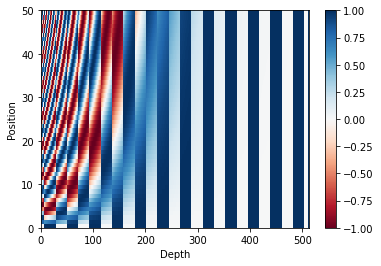

In [9]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
      
    pos_encoding = angle_rads[np.newaxis, ...]
      
    return tf.cast(pos_encoding, dtype=tf.float32)

pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

Позиционный эмбединг - это вектор плотности, который кодирует позицию слова в предложении: i-е позиционный эмбединг просто добавляется к встраиванию i-го слова в предложении. Здесь используются фиксированные позиционные эмбединг, определенные с помощью функций синуса и косинуса различных частот.

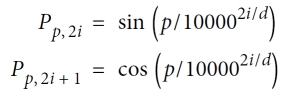

In [10]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    
    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [11]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

In [12]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.
    
    Args:
      q: query shape == (..., seq_len_q, depth)
      k: key shape == (..., seq_len_k, depth)
      v: value shape == (..., seq_len_v, depth_v)
      mask: Float tensor with shape broadcastable 
            to (..., seq_len_q, seq_len_k). Defaults to None.
      
    Returns:
      output
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
    
    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
          scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output


def print_out(q, k, v):
    temp_out = scaled_dot_product_attention(q, k, v, None)
    print ('Output is:')
    print (temp_out)
    
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [13]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
            
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
        
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)
        
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
        
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention = scaled_dot_product_attention(
            q, k, v, mask)
        
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
            
        return output

temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out = temp_mha(y, k=y, q=y, mask=None)
out.shape

TensorShape([1, 60, 512])

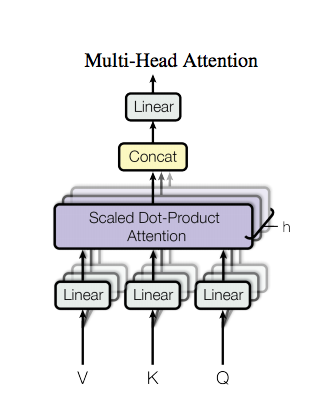

Multi-head attention. Это специальный новый слой, который дает возможность каждому входному вектору взаимодействовать с другими словами через attention mechanism, вместо передачи hidden state как в RNN или соседних слов как в CNN. Ему на вход даются вектора Query, и несколько пар Key и Value (на практике, Key и Value это всегда один и тот же вектор). Каждый из них преобразуется обучаемым линейным преобразованием, а потом вычисляется скалярное произведение Q со всеми K по очереди, прогоняется результат этих скалярных произведений через softmax, и с полученными весами все вектора V суммируются в единый вектор. таких attention'ов параллельно тренируется несколько (их количество на картинке обозначено через h), т.е. несколько линейных преобразований и параллельных скалярных произведений/взвешенных сумм. И потом результат всех этих параллельных attention'ов конкатенируется, еще раз прогоняется через обучаемое линейное преобразование и идет на выход.

In [14]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 60, 512))).shape

TensorShape([64, 60, 512])

In [15]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        
    def call(self, x, training, mask):

        attn_output = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
        
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
        
        return out2
    
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

In [16]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)
    
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
      
      
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        out1 = self.layernorm1(attn1 + x)
        
        attn2 = self.mha2(enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
        
        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
        
        return out3

sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output = sample_decoder_layer(tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

In [17]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                   maximum_position_encoding):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)
        
        
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff) 
                           for _ in range(num_layers)]
    
          
    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]
        
        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        
        return x  # (batch_size, input_seq_len, d_model)

sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


In [18]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
                   maximum_position_encoding):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff) 
                           for _ in range(num_layers)]
      
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        
        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        

        for i in range(self.num_layers):
            # x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)
            x = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)
            #attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            #attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
        
        # x.shape == (batch_size, target_seq_len, d_model)
        return x

sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape

TensorShape([64, 26, 512])

In [19]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                               input_vocab_size, pe_input)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                               target_vocab_size, pe_target)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
        
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):

        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
        
        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
        
        return final_output

sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

In [20]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = len(inp_lang.word_index)+1
target_vocab_size = len(targ_lang.word_index)+1

In [21]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [22]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [23]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2, output_type=tf.int32))
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [24]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size)

In [25]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)
    
    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)
    
    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    
    return enc_padding_mask, combined_mask, dec_padding_mask

In [26]:
EPOCHS = 20

# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function#(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    
    with tf.GradientTape() as tape:
        predictions = transformer(inp, tar_inp, 
                                  True, 
                                  enc_padding_mask, 
                                  combined_mask, 
                                  dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    
    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

In [36]:
checkpoint_path = os.path.join(WORK_PATH, "checkpoints/train")

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [37]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(dataset):
    train_step(inp, tar)

    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))

  #if (epoch + 1) % 5 == 0:
  ckpt_save_path = ckpt_manager.save()
  print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))


Epoch 1 Batch 0 Loss 0.5889 Accuracy 0.8798
Epoch 1 Batch 50 Loss 0.5499 Accuracy 0.8947
Epoch 1 Batch 100 Loss 0.5381 Accuracy 0.8946
Epoch 1 Batch 150 Loss 0.5316 Accuracy 0.8955
Epoch 1 Batch 200 Loss 0.5349 Accuracy 0.8947
Epoch 1 Batch 250 Loss 0.5381 Accuracy 0.8946
Epoch 1 Batch 300 Loss 0.5464 Accuracy 0.8941
Epoch 1 Batch 350 Loss 0.5477 Accuracy 0.8937
Epoch 1 Batch 400 Loss 0.5478 Accuracy 0.8936
Epoch 1 Batch 450 Loss 0.5508 Accuracy 0.8928
Epoch 1 Batch 500 Loss 0.5524 Accuracy 0.8927
Epoch 1 Batch 550 Loss 0.5531 Accuracy 0.8927
Epoch 1 Batch 600 Loss 0.5522 Accuracy 0.8928
Epoch 1 Batch 650 Loss 0.5514 Accuracy 0.8929
Epoch 1 Batch 700 Loss 0.5531 Accuracy 0.8927
Epoch 1 Batch 750 Loss 0.5551 Accuracy 0.8926
Epoch 1 Batch 800 Loss 0.5566 Accuracy 0.8925
Epoch 1 Batch 850 Loss 0.5563 Accuracy 0.8925
Epoch 1 Batch 900 Loss 0.5566 Accuracy 0.8924
Epoch 1 Batch 950 Loss 0.5572 Accuracy 0.8924
Epoch 1 Batch 1000 Loss 0.5575 Accuracy 0.8922
Epoch 1 Batch 1050 Loss 0.5581 Accur

# Evaluate

In [38]:
def evaluate(inp_sentence):
    
    # inp sentence is portuguese, hence adding the start and end token
    inp_sentence = inp_lang.texts_to_sequences([preprocess_sentence(inp_sentence)])
    encoder_input = tf.constant(inp_sentence)
    
    # as the target is english, the first word to the transformer should be the
    # english start token. 
    decoder_input = targ_lang.texts_to_sequences(["<start>"])
    output = tf.constant(decoder_input)
    MAX_LENGTH = 14
    for i in range(MAX_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)
    
        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions = transformer(encoder_input, 
                                  output,
                                  False,
                                  enc_padding_mask,
                                  combined_mask,
                                  dec_padding_mask)
        
        
        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)|
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        #inp_lang, targ_lang
        # return the result if the predicted_id is equal to the end token
        if predicted_id == targ_lang.texts_to_sequences(["<end>"]):
          output = tf.squeeze(output, axis=0)
          output = list(output.numpy())
          return output[1:]
        
        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    output = tf.squeeze(output, axis=0)
    output = list(output.numpy())
    return output[1:]

def translate(sentence):
  result = evaluate(sentence)
  
  predicted_sentence = targ_lang.sequences_to_texts([result])

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence[-1]))
  

In [39]:
translate("Я не хочу чтобы том страдал")

Input: Я не хочу чтобы том страдал
Predicted translation: i don't want tom to suffer .


In [42]:
translate("Привет, как дела?")

Input: Привет, как дела?
Predicted translation: hi . how are you ?


In [41]:
translate("Вот такая получилась модель")

Input: Вот такая получилась модель
Predicted translation: that's like a model model .


Как можно догадаться модель не может переводить новые слова, которые она не видела. Больше датасет - качественнее модель. Так же можно доработать правильную расстановку пунктуации и заглавных букв в именах собственных и в начале предложения. С помощью модели трансформера можно делать не только переводчики, но и генераторы новых текстов, работает по такому же принципу, но нужны другие входные данные.